In [23]:
# 复制s3内容到本地目录
import warnings
warnings.filterwarnings("ignore")
import os,sys, shutil
mox.file.shift('os', 'mox')
shutil.copytree("s3://youziyolo/youzi/src","./src")

* 导入所需的Python库

In [24]:
import os
import warnings
import cv2
import logging
import random
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt

import moxing as mox
from modelarts.session import Session
from src.utils.lr_schedular import WarmUpMultiFactorScheduler
from src.utils.lr_schedular import WarmUpMultiFactorScheduler
from src.utils.yolo_metric import YoloLoss
from src.data.yolo_dataset import get_data_iter
from src.symbol.yolov3 import get_symbol

%matplotlib inline

In [25]:
os.environ['MXNET_BACKWARD_DO_MIRROR'] = '1'
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)                

# 初始化session，用于对OBS操作
session =Session()

In [26]:
BATCH_SIZE = 1  
NUM_CLASSES = 1
NUM_EXAMPLES = 20
OFFSETS = [(13, 13), (26, 26), (52, 52)]
ANCHORS = [[116, 90, 156, 198, 373, 326],                 
           [30, 61, 62, 45, 59, 119],
           [10, 13, 16, 30, 33, 23]]

In [27]:
# get_symbol函数返回mx.sym.Symbol类型的变量
yolo_v3_net = get_symbol(num_classes=1,                             # 模型分类数
                         is_train=True)                             # 是否用于训练任务

## 模型构建

###### 1. 新建mxnet构建模块

将mxnet.mod.Module模块看做一个计算引擎，它包含了计算图生成和绑定、参数初始化、前向计算、后向计算、参数更新、模型保存、日志打印等相关逻辑。
初始化该模块需要传入模型结构以及计算使用的硬件环境，[参考](http://mxnet.incubator.apache.org/api/python/module/module.html#mxnet.module.Module).




In [28]:
# 设置计算环境CPU or GPU：devs = mx.cpu(0), devs = mx.gpu(0)
devs = mx.cpu(0)
model = mx.mod.Module(context=devs,                                                                           # 计算设备
                      symbol=yolo_v3_net,                                                                     # 模型结构
                      data_names=['data'],                                                                    # 模型中使用的输入数据名称
                      label_names=['gt_boxes', 'obj_t', 'centers_t', 'scales_t', 'weights_t', 'clas_t'])      # 模型中使用的输入标签名称

In [29]:
# 将目标框扩展成所需的shape
def get_anchors(anchors):
    anchor_list = []
    for item in anchors:
        anchor = mx.nd.array(item)
        anchor = anchor.reshape(1, 1, -1, 2)
        anchor_list.append(anchor)
    return anchor_list

# 将偏移量扩展成所需的shape
def get_offsets(offsets):
    offset_list = []
    for item in offsets:
        grid_x = np.arange(item[1])
        grid_y = np.arange(item[0])
        grid_x, grid_y = np.meshgrid(grid_x, grid_y)
        offset = np.concatenate((grid_x[:, :, np.newaxis], grid_y[:, :, np.newaxis]), axis=-1)
        offset = np.expand_dims(np.expand_dims(offset, axis=0), axis=0)
        offset = mx.nd.array(offset).reshape(1, -1, 1, 2)
        offset_list.append(offset)
    return offset_list

# offset、anchor参数，采用常量初始化；其它参数采用Xavier初始化
offset_data = get_offsets(OFFSETS)
anchor_data = get_anchors(ANCHORS)

initializer = mx.init.Mixed(['offset_0_weight', 'offset_1_weight', 'offset_2_weight',
                             'anchors_0_weight', 'anchors_1_weight', 'anchors_2_weight',
                             '.*'],
                            [mx.init.Constant(offset_data[0]),
                             mx.init.Constant(offset_data[1]),
                             mx.init.Constant(offset_data[2]),
                             mx.init.Constant(anchor_data[0]),
                             mx.init.Constant(anchor_data[1]),
                             mx.init.Constant(anchor_data[2]),
                             mx.init.Xavier(factor_type="in", magnitude=2.34)])

In [30]:
# 设置参数同步方式
kv = mx.kvstore.create('local')

# 设置Loss打印
from src.utils.yolo_metric import YoloLoss
metrics = [YoloLoss(name='ObjLoss', index=0),
           YoloLoss(name='BoxCenterLoss', index=1),
           YoloLoss(name='BoxScaleLoss', index=2),
           YoloLoss(name='ClassLoss', index=3)]

## 模型推理测试
###### 1.读取测试图片

可以从s3获取具体数据

In [32]:
import shutil
shutil.copyfile("s3://youziyolo/output/model/model/fine_tune-symbol.json","./fine_tune-symbol.json")
shutil.copyfile("s3://youziyolo/output/model/model/fine_tune-0000.params","./fine_tune-0000.params")
os.listdir(".")

['.idea', 'src', 'fine_tune-symbol.json', 'fine_tune-0000.params']

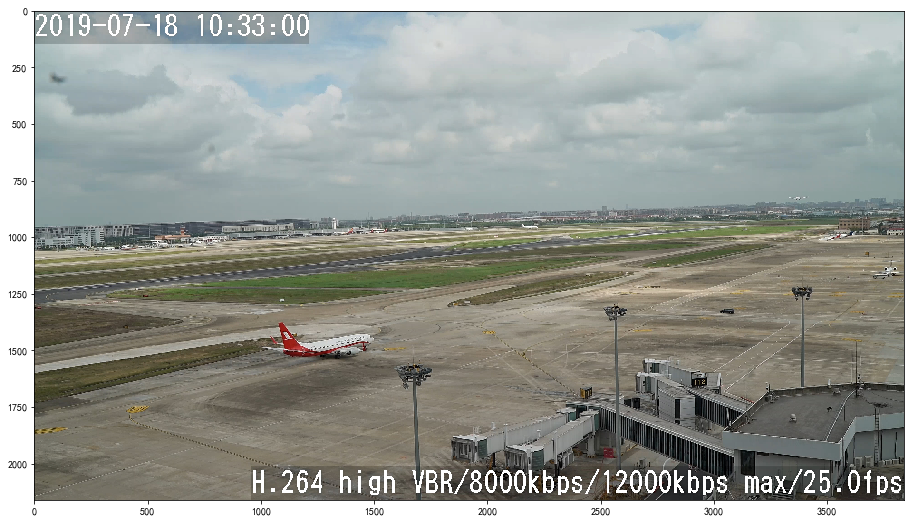

In [33]:
# 图片保存位置
file_name = os.path.join("s3://youziyolo/youzi/data/flight_test1.jpg")

# 图像输入的长宽
h=416
w=416

# 图像归一化需要的均值和方差
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

# 以二进制形式，将图片读入内存
img = mox.file.read(file_name, binary=True)

# 保存原图，用于展示
plt.figure(figsize=(16,9))
orig_img = mx.img.imdecode(img, to_rgb=1).asnumpy().astype('uint8')
plt.imshow(orig_img)
plt.show()

# 图像预处理，归一化，resize，用于模型推理
img = mx.img.imdecode(img, 1)
img = mx.image.imresize(img, w, h, interp=2)
img = mx.nd.image.to_tensor(img)
img = mx.nd.image.normalize(img, mean=mean, std=std).expand_dims(0)

# 准备输入数据
provide_data = [mx.io.DataDesc(name='data', shape=(1, 3, h, w))]
batch_data = mx.io.DataBatch(data=[img], provide_data=provide_data)

###### 2.加载训练完成的模型文件
加载前面训练出的模型，模型保存在本地路径checkpoint_prefix中。

In [35]:
# 模型保存编号,请根据实际情况设置
load_epoch = 1
# 参数保存在arg_params，aux_params中
_, arg_params, aux_params = mx.model.load_checkpoint("./fine_tune", 0)          

###### 3.加载推理使用的模型结构
与训练不同，此时的模型不再包含损失函数，模型输出也被整理成\[分类结果，置信度，边框坐标\]的形式。模型参数不变。

In [36]:
yolo_v3_net_pre = get_symbol(num_classes=NUM_CLASSES,                  # 模型分类数
                             is_train=False)                           # 模型结构用于推理


###### 4.新建mxnet推理模块
同样是mxnet.mod.Module模块，相比训练时，此时的计算逻辑去除了反向传播和参数更新。

In [37]:
devs = mx.cpu(0)

model_pre = mx.mod.Module(
         context=mx.cpu(),                         # 使用cpu进行推理
         symbol=yolo_v3_net_pre,                   # 推理模型结构
         data_names=['data'],                      # 输入数据的名称，与前面准备输入数据时provide_data中的名称相同
         label_names=None)                         # 推理无需输入label

model_pre.bind(for_training=False,                       #绑定计算模块到底层计算引擎
           data_shapes=batch_data.provide_data,
           label_shapes=None)

model_pre.set_params(arg_params, aux_params)             # 将下载的训练完成的参数加载进计算模块

###### 5.执行推理计算

In [38]:
model_pre.forward(batch_data,                                        # 输入数据
                  is_train=False)                                   # 控制引擎只进行前向计算

# 获得推理结果
pred = model_pre.get_outputs()                                      
ids, scores, bboxes = [xx[0].asnumpy() for xx in pred]

###### 6. 解析并绘制结果
预测结果，取决于训练时epoch大小。epoch太大，在CPU场景下训练耗时较长，建议选择GPU训练。
* 根据设置的置信度，可能会输出多个矩形框。
* 由于训练数据量少，训练时间短，推理任务加载的模型精度较低，画出的目标框会存在不准确的现象。
* 适当调整优化器参数，延长训练步数会提升模型精度。
* <font color = red>在num_epoch=20时，模型精度较好</font>

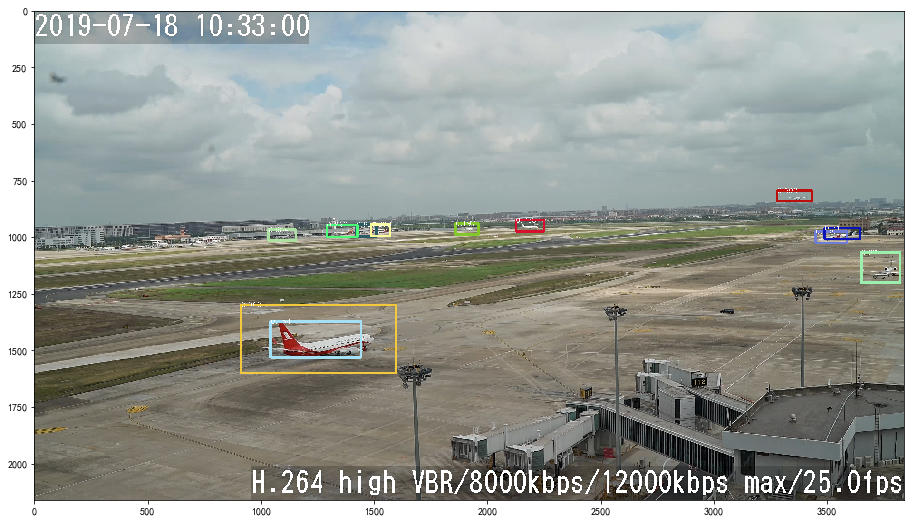

In [39]:
# 置信度阈值
THRESH = 0.05

im_array = orig_img.copy()
color_white = (255, 255, 255)
x_scale = im_array.shape[1] / 416.0
y_scale = im_array.shape[0] / 416.0

for idx in range(ids.shape[0]):
    if ids[idx][0] < 0 or scores[idx][0] < THRESH:
        continue
    # 按原图比例缩放目标框
    bbox = [int(bboxes[idx][0] * x_scale),
            int(bboxes[idx][1] * y_scale),
            int(bboxes[idx][2] * x_scale),
            int(bboxes[idx][3] * y_scale)]
    color = (random.randint(0, 256), random.randint(0, 256), random.randint(0, 256))
    
    # 在图像上画框
    cv2.rectangle(im_array, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=color, thickness=10)
    
    # 把置信度写在图像上
    cv2.putText(im_array, '%.3f' % (scores[idx][0]), (bbox[0], bbox[1] + 10),
                color=color_white, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1)
plt.figure(figsize=(16,9))
plt.imshow(im_array)
plt.show()